# **Synthetic Dental X-Ray Generation and Segmentation Analysis**

## Imports

Imports

In [58]:
import os, glob, time, random, sys
import numpy as np
from PIL import Image, ImageOps, ImageFilter
import matplotlib.pyplot as plt
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid, save_image
import torch.optim as optim

import cv2

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

Environment report

In [59]:
print("Environment")
print("-----------")
print(f"Python        : {sys.version.split()[0]}")
print(f"NumPy         : {np.__version__}")
print(f"PyTorch       : {torch.__version__}")
print(f"OpenCV        : {cv2.__version__}")
print()

# CUDA / device check
if torch.cuda.is_available():
    print("CUDA available")
    print(f"GPU           : {torch.cuda.get_device_name(0)}")
    print(f"CUDA version  : {torch.version.cuda}")
    print(f"cuDNN         : {torch.backends.cudnn.version()}")
else:
    print("CUDA NOT available (training will be slow)")

Environment
-----------
Python        : 3.10.11
NumPy         : 2.2.6
PyTorch       : 2.8.0+cu128
OpenCV        : 4.12.0

CUDA available
GPU           : NVIDIA GeForce RTX 2060
CUDA version  : 12.8
cuDNN         : 91002


## Globals

In [60]:
SEED = 13
PROJECT_ROOT = Path("../workspace")
DATA_ROOT_IMG = PROJECT_ROOT / "teeth_seg_dataset/d2/img"
MASK_DIR = PROJECT_ROOT / "teeth_seg_dataset/d2/masks_machine"
IMG_SIZE = 256
BATCH_SIZE = 16
NUM_WORKERS = 2
CHANNELS = 1
EPOCHS = 10
LR = 2e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LATENT_DIM = 100
BETA1 = 0.5
BETA2 = 0.999

## Utils

In [61]:
def set_seed(seed: int=13):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)

In [62]:
def pad_to_square(img, fill=0):
    w, h = img.size
    if w == h: return img
    s = max(w, h)
    out = Image.new(img.mode, (s, s), color=fill)
    out.paste(img, ((s - w) // 2, (s - h) // 2))
    return out

In [63]:
def to_tensor_gray(img):
    if img.mode != "L": img = img.convert("L")
    arr = np.array(img, dtype=np.float32) / 255.0   # (H, W)
    arr = arr[None, ...]    # (1, H, W)
    return torch.from_numpy(arr)

In [64]:
def denorm(x):
    # [-1, 1] -> [0, 1]
    return (x.clamp(-1, 1) + 1) * 0.5

In [65]:
def show_grid(t, nrow=8, title=None):
    g = make_grid(denorm(t.detach().cpu()), nrow=nrow, padding=2)
    g_np = g.squeeze(0).permute(1, 2, 0).numpy()
    plt.figure(figsize=(22, 16), dpi=160)
    plt.axis("off")
    if title: plt.title(title)
    plt.imshow(g_np.squeeze(), cmap="gray")
    plt.show()

In [66]:
# custom weights initialization called on 'netG' and 'netD'
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Data

In [67]:
def list_image_files(root):
    return sorted(glob.glob(os.path.join(root, "**", "*.jpg"), recursive=True))

class DentalXRays(Dataset):
    def __init__(self, root, size=256):
        super().__init__()
        self.paths = list_image_files(root)
        self.size = size
        if not self.paths:
            print(f"[WARNING] No .jpg images found under: {root}")

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        img = Image.open(p).convert("L")
        img = pad_to_square(img, fill=0)
        img = img.resize((self.size, self.size), resample=Image.BICUBIC)
        t = to_tensor_gray(img) # [0, 1]
        t = t * 2.0 - 1.0   # [-1, 1] for GAN
        return t

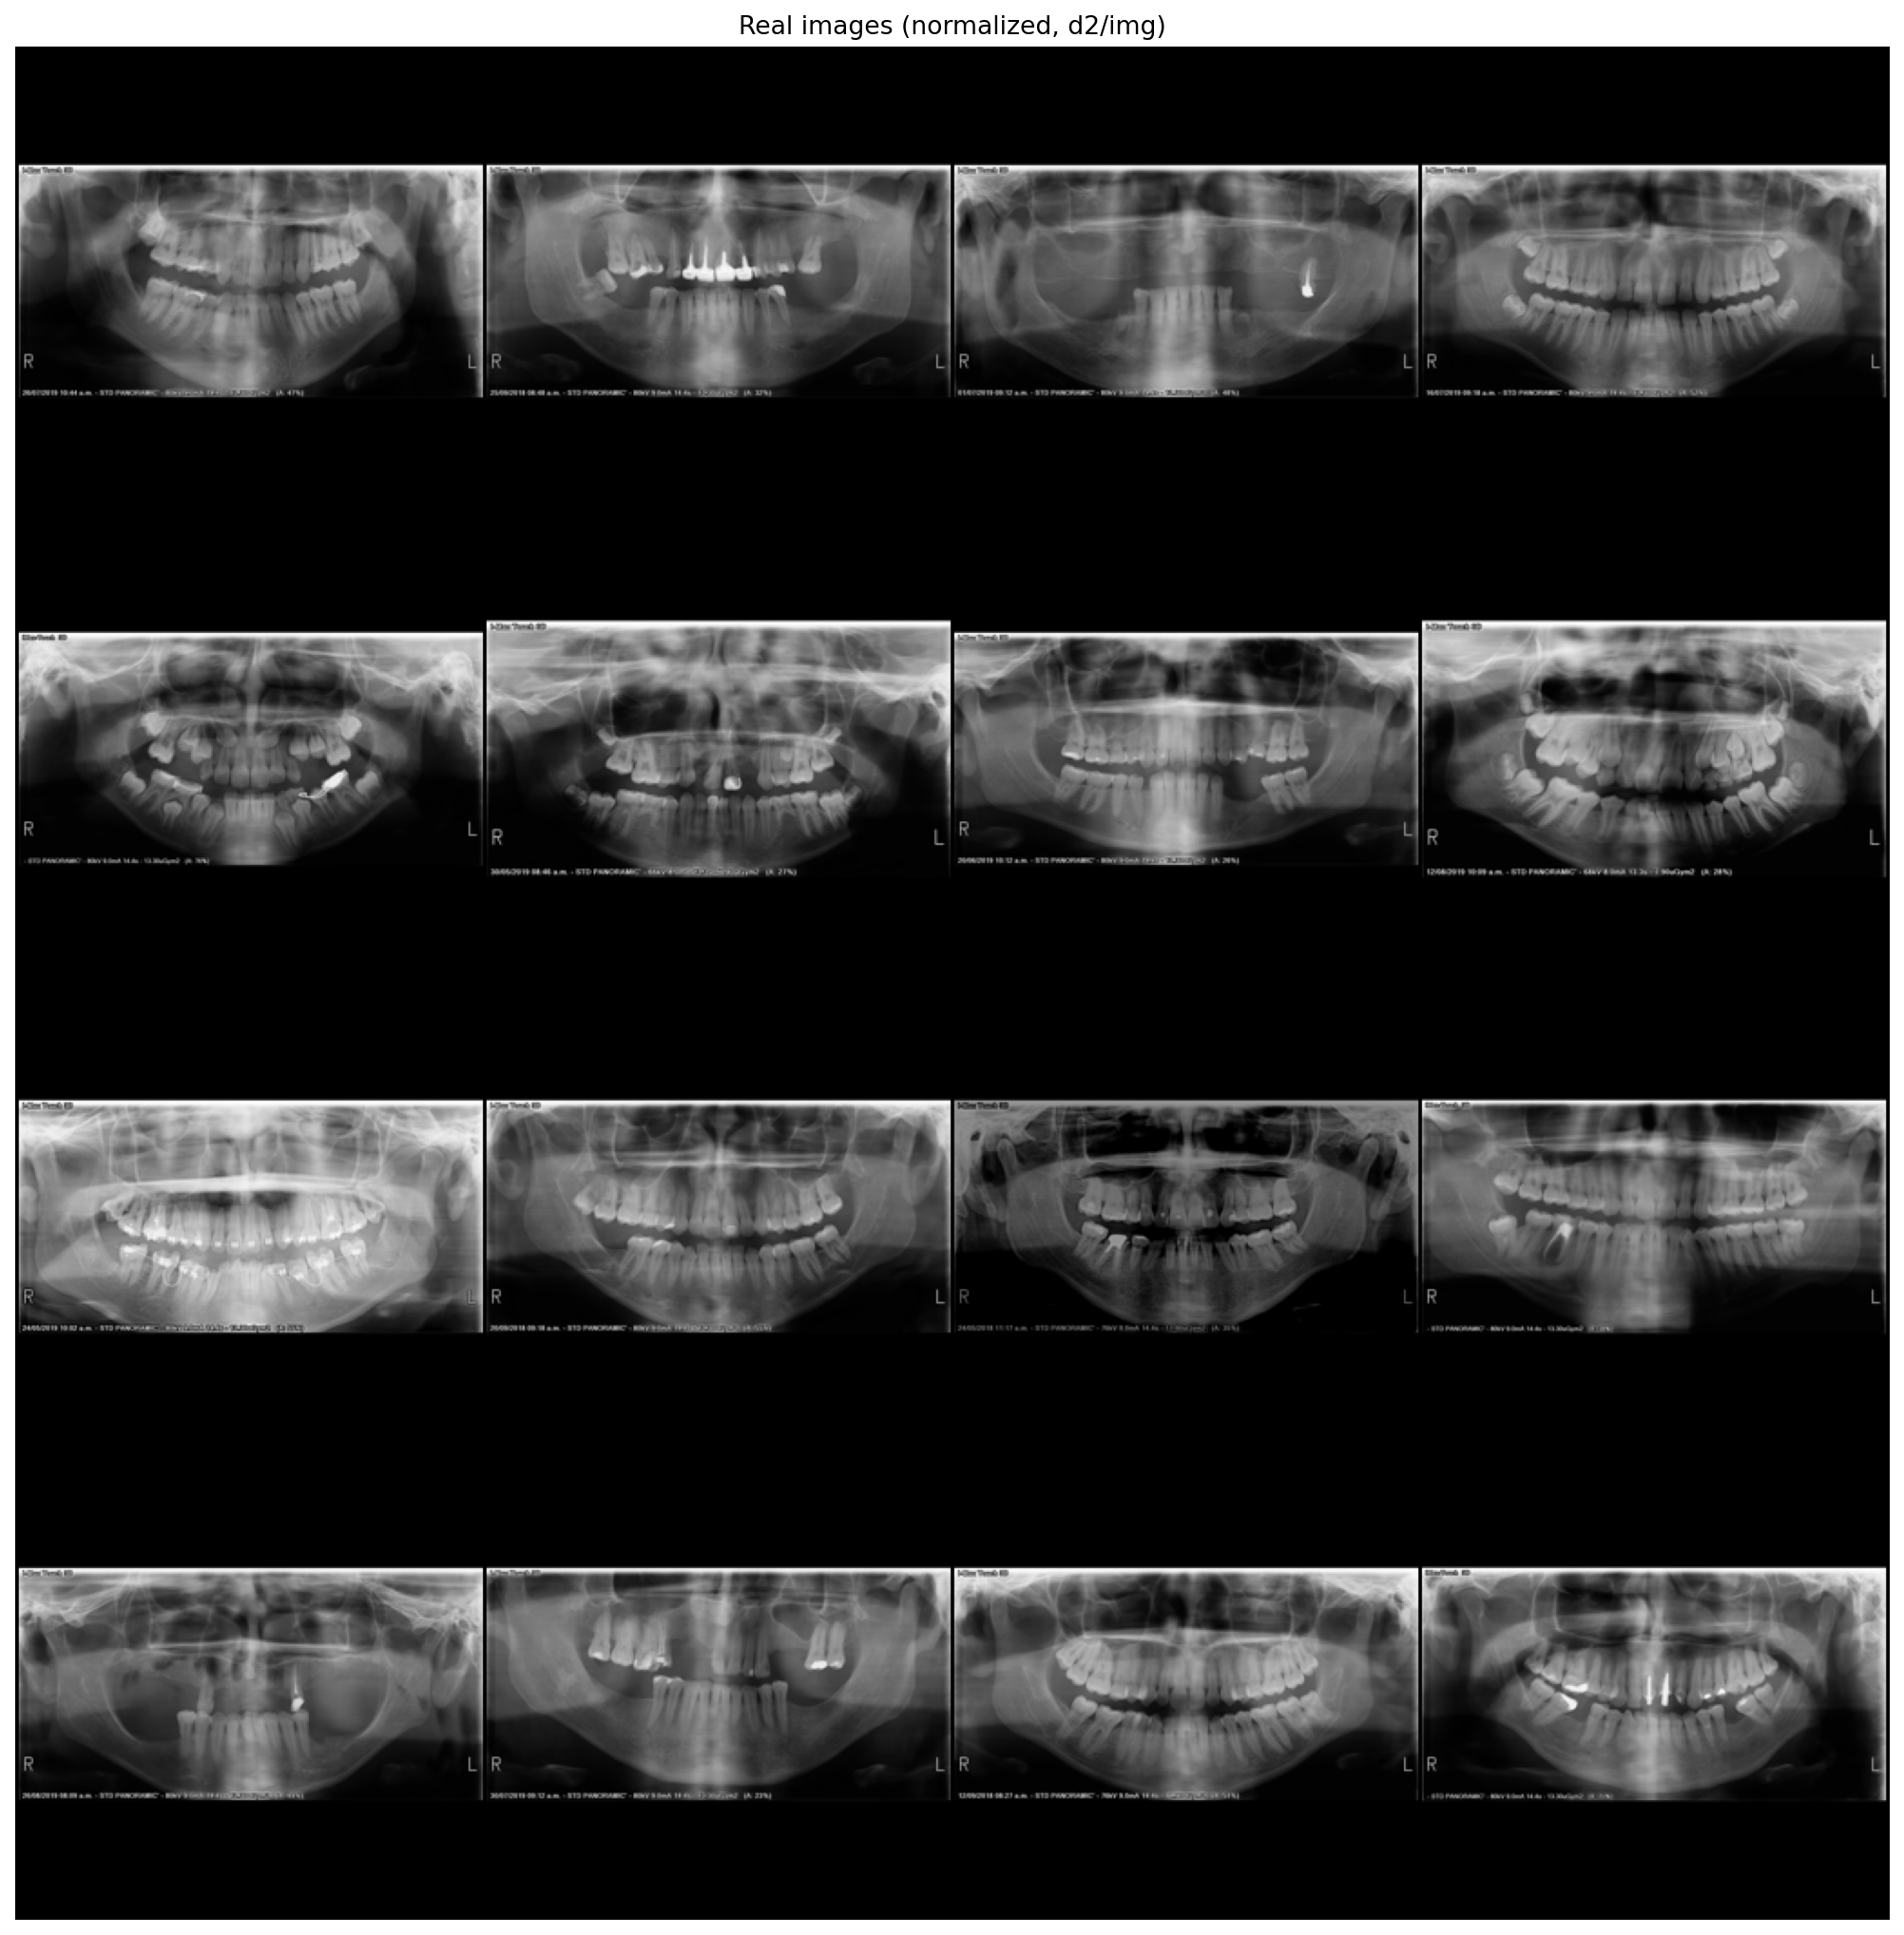

Loaded 598 .jpg images from ../workspace/teeth_seg_dataset/d2/img
torch.Size([16, 1, 256, 256])


In [68]:
dataset = DentalXRays(DATA_ROOT_IMG, IMG_SIZE)
if len(dataset) == 0:
    raise RuntimeError(f"No .jpg images in {DATA_ROOT_IMG}")
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=True)

# Quick visual sanity check
batch = next(iter(loader))
show_grid(batch[:16], nrow=4, title="Real images (normalized, d2/img)")
print(f"Loaded {len(dataset)} .jpg images from {DATA_ROOT_IMG}")
print(batch.size())

## Network

###### Vanilla GAN

In [13]:
class Generator(nn.Module):
    def __init__(self, latent_dim, base_ch=512):
        super(Generator, self).__init__()

        self.base_ch = base_ch
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, base_ch * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (base_ch, 4, 4)),
        )

        # 4x4 -> 8 -> 16 -> 32 -> 64 -> 128 -> 256
        def up(in_c, out_c):
            return nn.Sequential(
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c, momentum=0.78),
                nn.ReLU(),
            )

        self.conv = nn.Sequential(
            up(base_ch, base_ch // 2),          # 4     -> 8
            up(base_ch // 2, base_ch // 4),     # 8     -> 16
            up(base_ch // 4, base_ch // 8),     # 16    -> 32
            up(base_ch // 8, base_ch // 16),    # 32    -> 64
            up(base_ch // 16, base_ch // 32),   # 64    -> 128
            up(base_ch // 32, base_ch // 64),   # 128   -> 256
            nn.Conv2d(base_ch // 64, 1, kernel_size=3, padding=1),
            nn.Tanh(),  # output in [-1, 1]
        )

    def forward(self, z):
        x = self.fc(z)
        return self.conv(x)

In [14]:
class Discriminator(nn.Module):
    def __init__(self, base_ch = 64):
        super(Discriminator, self).__init__()

        def down(in_c, out_c, bn=True, zp=False):
            layers = [nn.Conv2d(in_c, out_c, kernel_size=3, stride=2, padding=1)]
            if zp:
                layers.append(nn.ZeroPad2d((0, 1, 0, 1)))
            if bn:
                layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.25))
            layers.append(nn.Dropout(0.25))
            return nn.Sequential(*layers)

        self.features = nn.Sequential(
            down(1, base_ch, bn=False),             # 256   -> 128
            down(base_ch, base_ch * 2, zp=False),   # 128   -> 64
            down(base_ch * 2, base_ch * 4),         # 64    -> 32
            down(base_ch * 4, base_ch * 8),         # 32    -> 16
            down(base_ch * 8, base_ch * 8),         # 16    -> 8
            down(base_ch * 8, base_ch * 8),         # 8     -> 4
        )

        self.clf = nn.Sequential(
            nn.Flatten(),
            nn.Linear(base_ch * 8 * 4 * 4, 1),
            nn.Sigmoid(),   # output in [0, 1]
        )

    def forward(self, img):
        x = self.features(img)
        return self.clf(x)

###### DCGAN

In [69]:
class DCGenerator(nn.Module):
    def __init__(self, latent_dim, base_ch=512):
        super(DCGenerator, self).__init__()

        self.base_ch = base_ch
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, base_ch * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (base_ch, 4, 4)),
        )

        # 4x4 -> 8 -> 16 -> 32 -> 64 -> 128 -> 256
        def up(in_c, out_c, stride=2, pad=1):
            return nn.Sequential(
                # nn.Upsample(scale_factor=2),
                # nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ConvTranspose2d(in_c, out_c, kernel_size=4, stride=stride, padding=pad, bias=False),
                nn.BatchNorm2d(out_c),
                nn.ReLU(True),
            )

        self.conv = nn.Sequential(
            up(base_ch, base_ch // 2, stride=2, pad=1), # 4     -> 8
            up(base_ch // 2, base_ch // 4),             # 8     -> 16
            up(base_ch // 4, base_ch // 8),             # 16    -> 32
            up(base_ch // 8, base_ch // 16),            # 32    -> 64
            up(base_ch // 16, base_ch // 32),           # 64    -> 128
            up(base_ch // 32, base_ch // 64),           # 128   -> 256
            up(base_ch // 64, base_ch // 64),           # 128   -> 256
            nn.Conv2d(base_ch // 64, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),  # output in [-1, 1]
        )

    def forward(self, z):
        x = self.fc(z)
        return self.conv(x)

In [70]:
class DCDiscriminator(nn.Module):
    def __init__(self, base_ch = 64):
        super(DCDiscriminator, self).__init__()

        def down(in_c, out_c, stride=2, padding=1, bn=True, zp=False):
            layers = [nn.Conv2d(in_c, out_c, kernel_size=4, stride=stride, padding=padding, bias=False)]
            if zp:
                layers.append(nn.ZeroPad2d((0, 1, 0, 1)))
            if bn:
                layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.25, inplace=True))
            # layers.append(nn.Dropout(0.25))
            return nn.Sequential(*layers)

        self.features = nn.Sequential(
            down(1, base_ch, bn=False),                             # 256   -> 128
            down(base_ch, base_ch * 2),                             # 128   -> 64
            down(base_ch * 2, base_ch * 4),                         # 64    -> 32
            down(base_ch * 4, base_ch * 8),                         # 32    -> 16
            down(base_ch * 8, base_ch * 8),                         # 16    -> 8
            down(base_ch * 8, base_ch * 8, stride=2, padding=1),    # 8     -> 4
        )

        self.clf = nn.Sequential(
            nn.Flatten(),
            nn.Linear(base_ch * 8 * 4 * 4, 1),
            nn.Sigmoid(),   # output in [0, 1]
        )

    def forward(self, img):
        x = self.features(img)
        return self.clf(x)

## Train

###### Vanilla GAN

In [15]:
generator = Generator(LATENT_DIM).to(DEVICE)
discriminator = Discriminator().to(DEVICE)

adversarial_loss = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=LR, betas=(BETA1, BETA2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=LR, betas=(BETA1, BETA2))

Vanilla GAN 10 epochs.:  90%|█████████ | 9/10 [01:32<00:10, 10.08s/it]

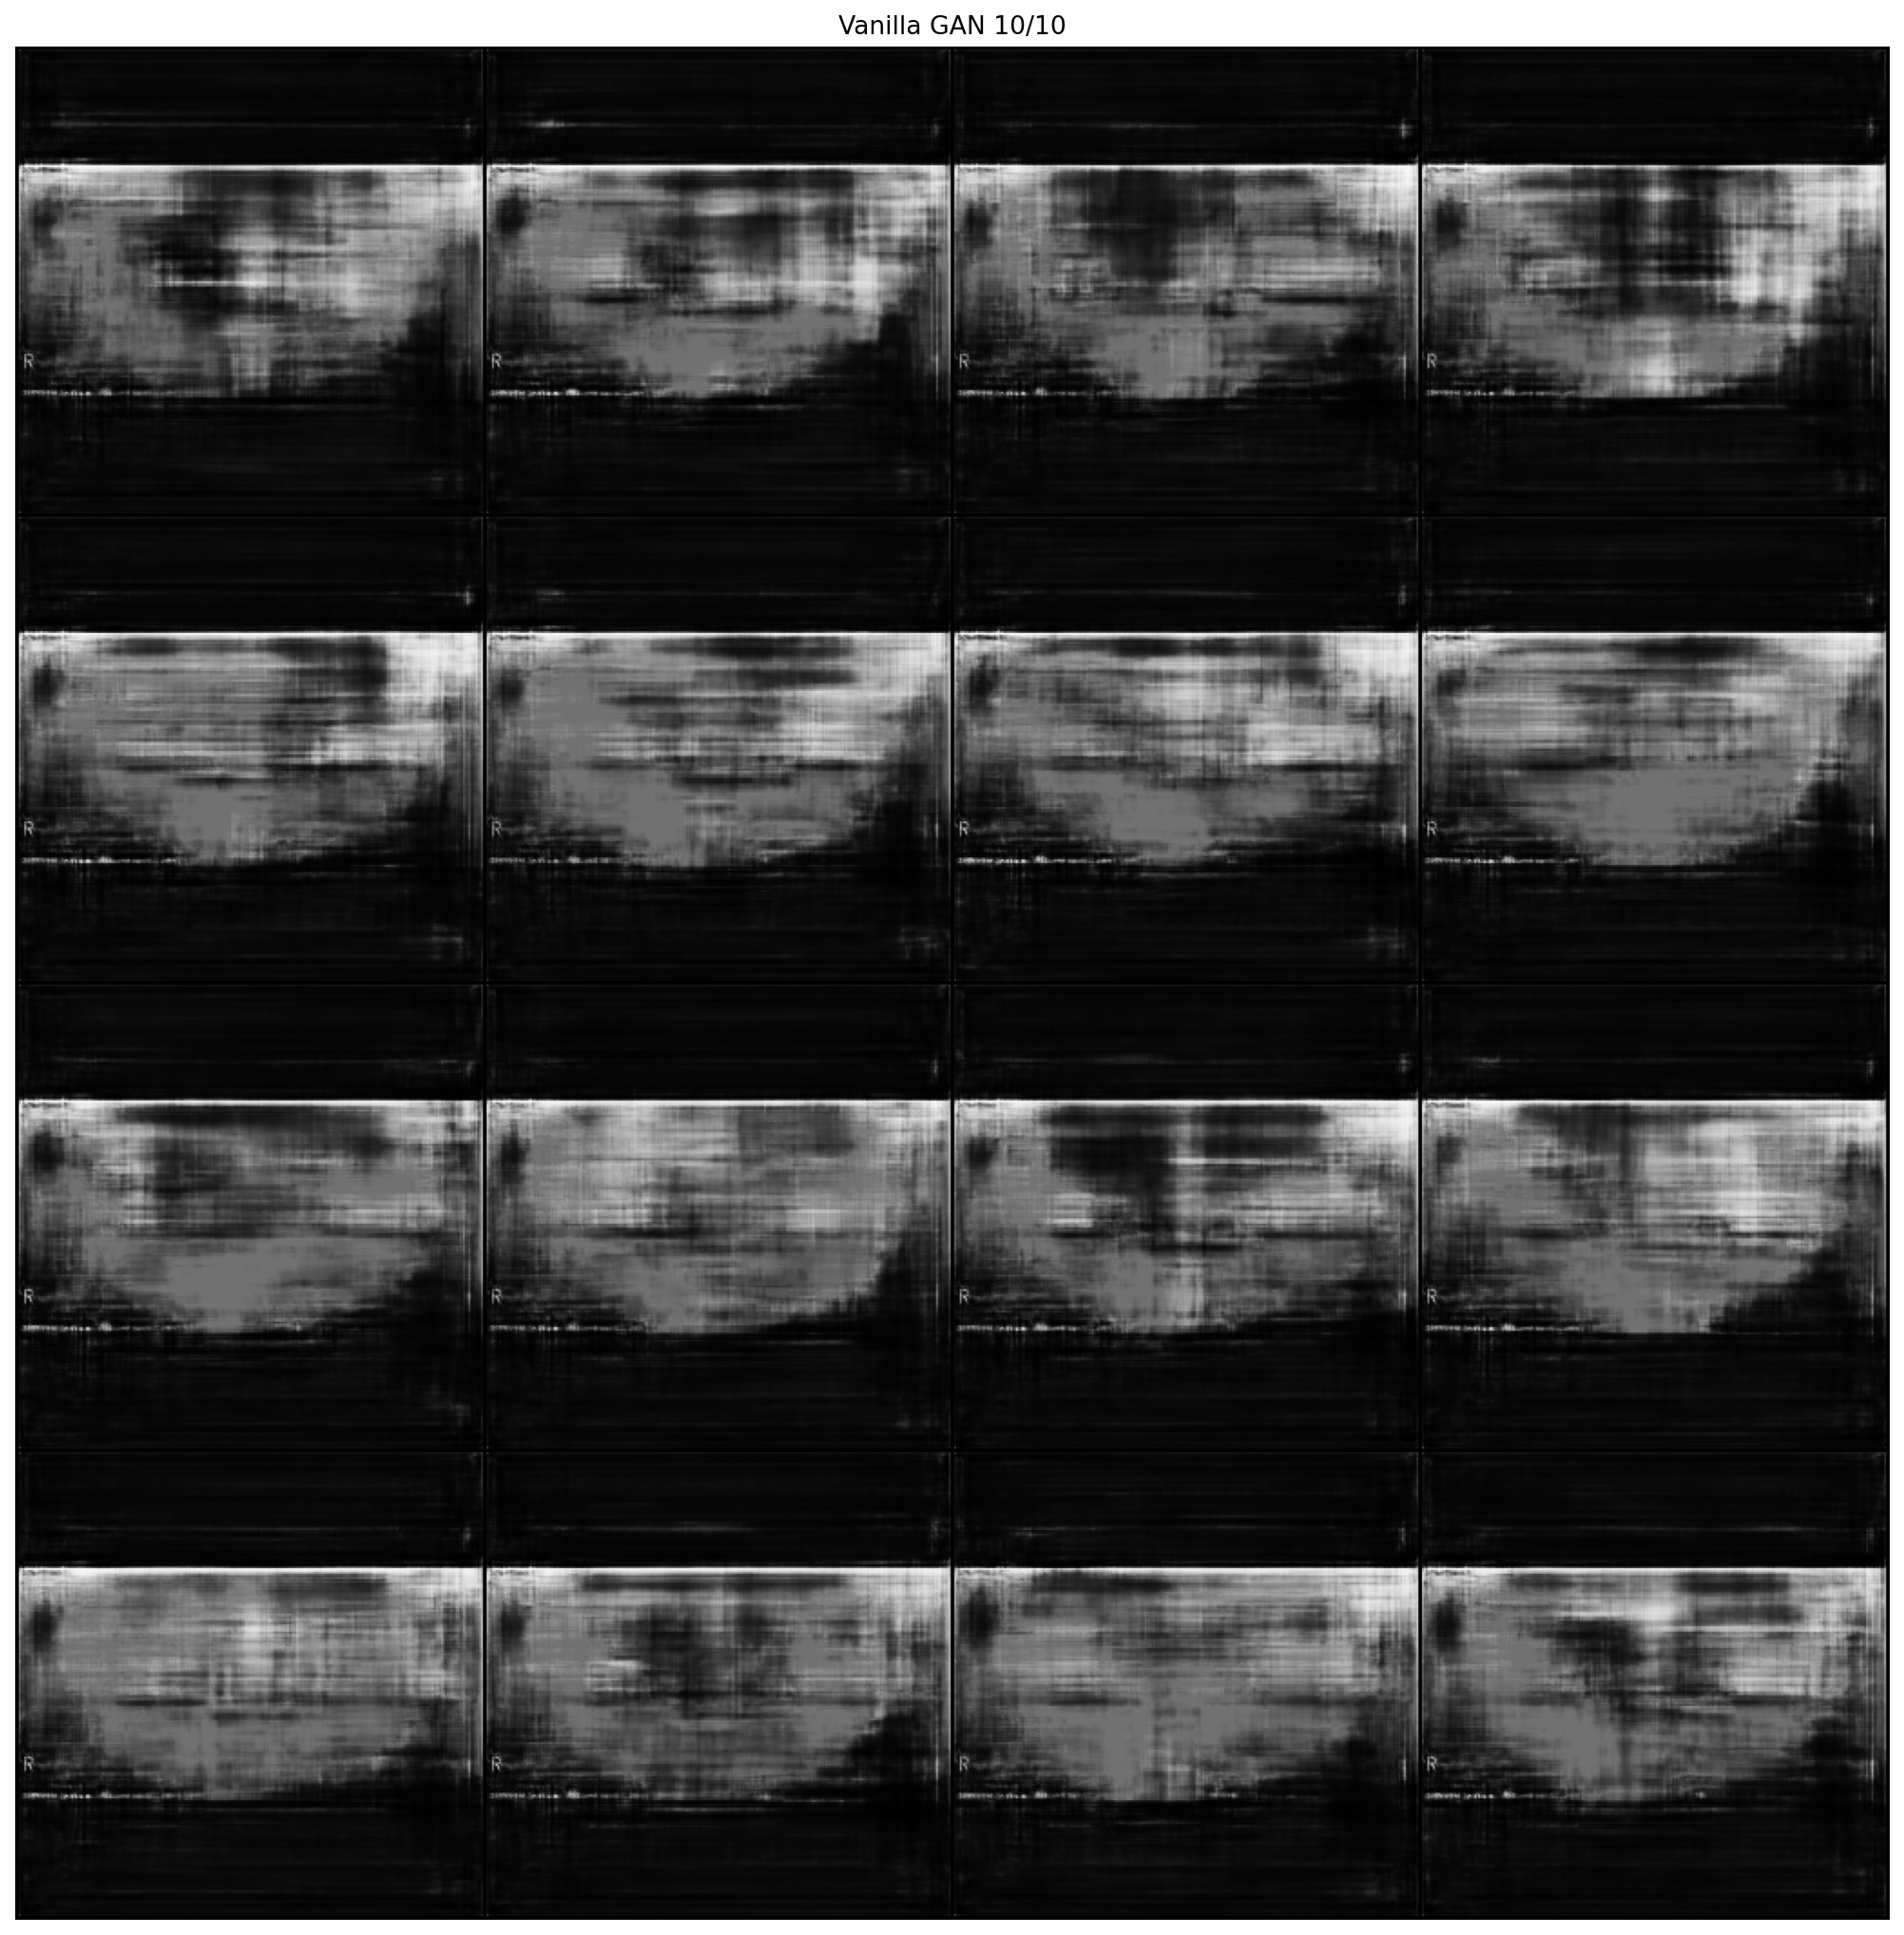

Vanilla GAN 10 epochs.: 100%|██████████| 10/10 [01:43<00:00, 10.38s/it]

Gen Images Size: torch.Size([16, 1, 256, 256])


In [16]:
for epoch in tqdm(range(EPOCHS), desc=f"Vanilla GAN {EPOCHS} epochs."):
    for i, batch in enumerate(loader):

        real_images = batch.to(DEVICE)

        valid = torch.ones(real_images.size(0), 1, device=DEVICE)
        fake = torch.zeros(real_images.size(0), 1, device=DEVICE)

        real_images = real_images.to(DEVICE)

        optimizer_D.zero_grad()

        z = torch.randn(real_images.size(0), LATENT_DIM, device=DEVICE)

        fake_images = generator(z)

        real_loss = adversarial_loss(discriminator(real_images), valid)
        fake_loss = adversarial_loss(discriminator(fake_images.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        gen_images = generator(z)

        g_loss = adversarial_loss(discriminator(gen_images), valid)
        g_loss.backward()
        optimizer_G.step()

        if (i + 1) % 100 == 0:
            print(
                f"Epoch [{epoch+1}/{EPOCHS}]\
                        Batch {i+1}/{len(loader)} "
                f"Discriminator Loss: {d_loss.item():.4f} "
                f"Generator Loss: {g_loss.item():.4f}"
            )
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            z = torch.randn(16, LATENT_DIM, device=DEVICE)
            generated = generator(z).detach().cpu()
            # grid = make_grid(generated, nrow=4, normalize=True)
            # plt.imshow(np.transpose(grid, (1, 2, 0)))
            # plt.axis("off")
            # plt.show()
            show_grid(generated, nrow=4, title=f"Vanilla GAN {epoch + 1}/{EPOCHS}")
            print(f"\nGen Images Size: {generated.size()}")

###### DCGAN

In [71]:
DC_generator = DCGenerator(LATENT_DIM).to(DEVICE)
DC_discriminator = DCDiscriminator().to(DEVICE)

DC_generator.apply(weights_init)
DC_discriminator.apply(weights_init)

DC_adversarial_loss = nn.BCELoss()

DC_optimizer_G = optim.Adam(DC_generator.parameters(), lr=LR, betas=(BETA1, BETA2))
DC_optimizer_D = optim.Adam(DC_discriminator.parameters(), lr=LR, betas=(BETA1, BETA2))

print(DC_generator)
print(DC_discriminator)

DCGenerator(
  (fc): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(512, 4, 4))
  )
  (conv): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(64, 32, kerne

DCGAN 10 epochs.:  90%|█████████ | 9/10 [01:43<00:11, 11.53s/it]

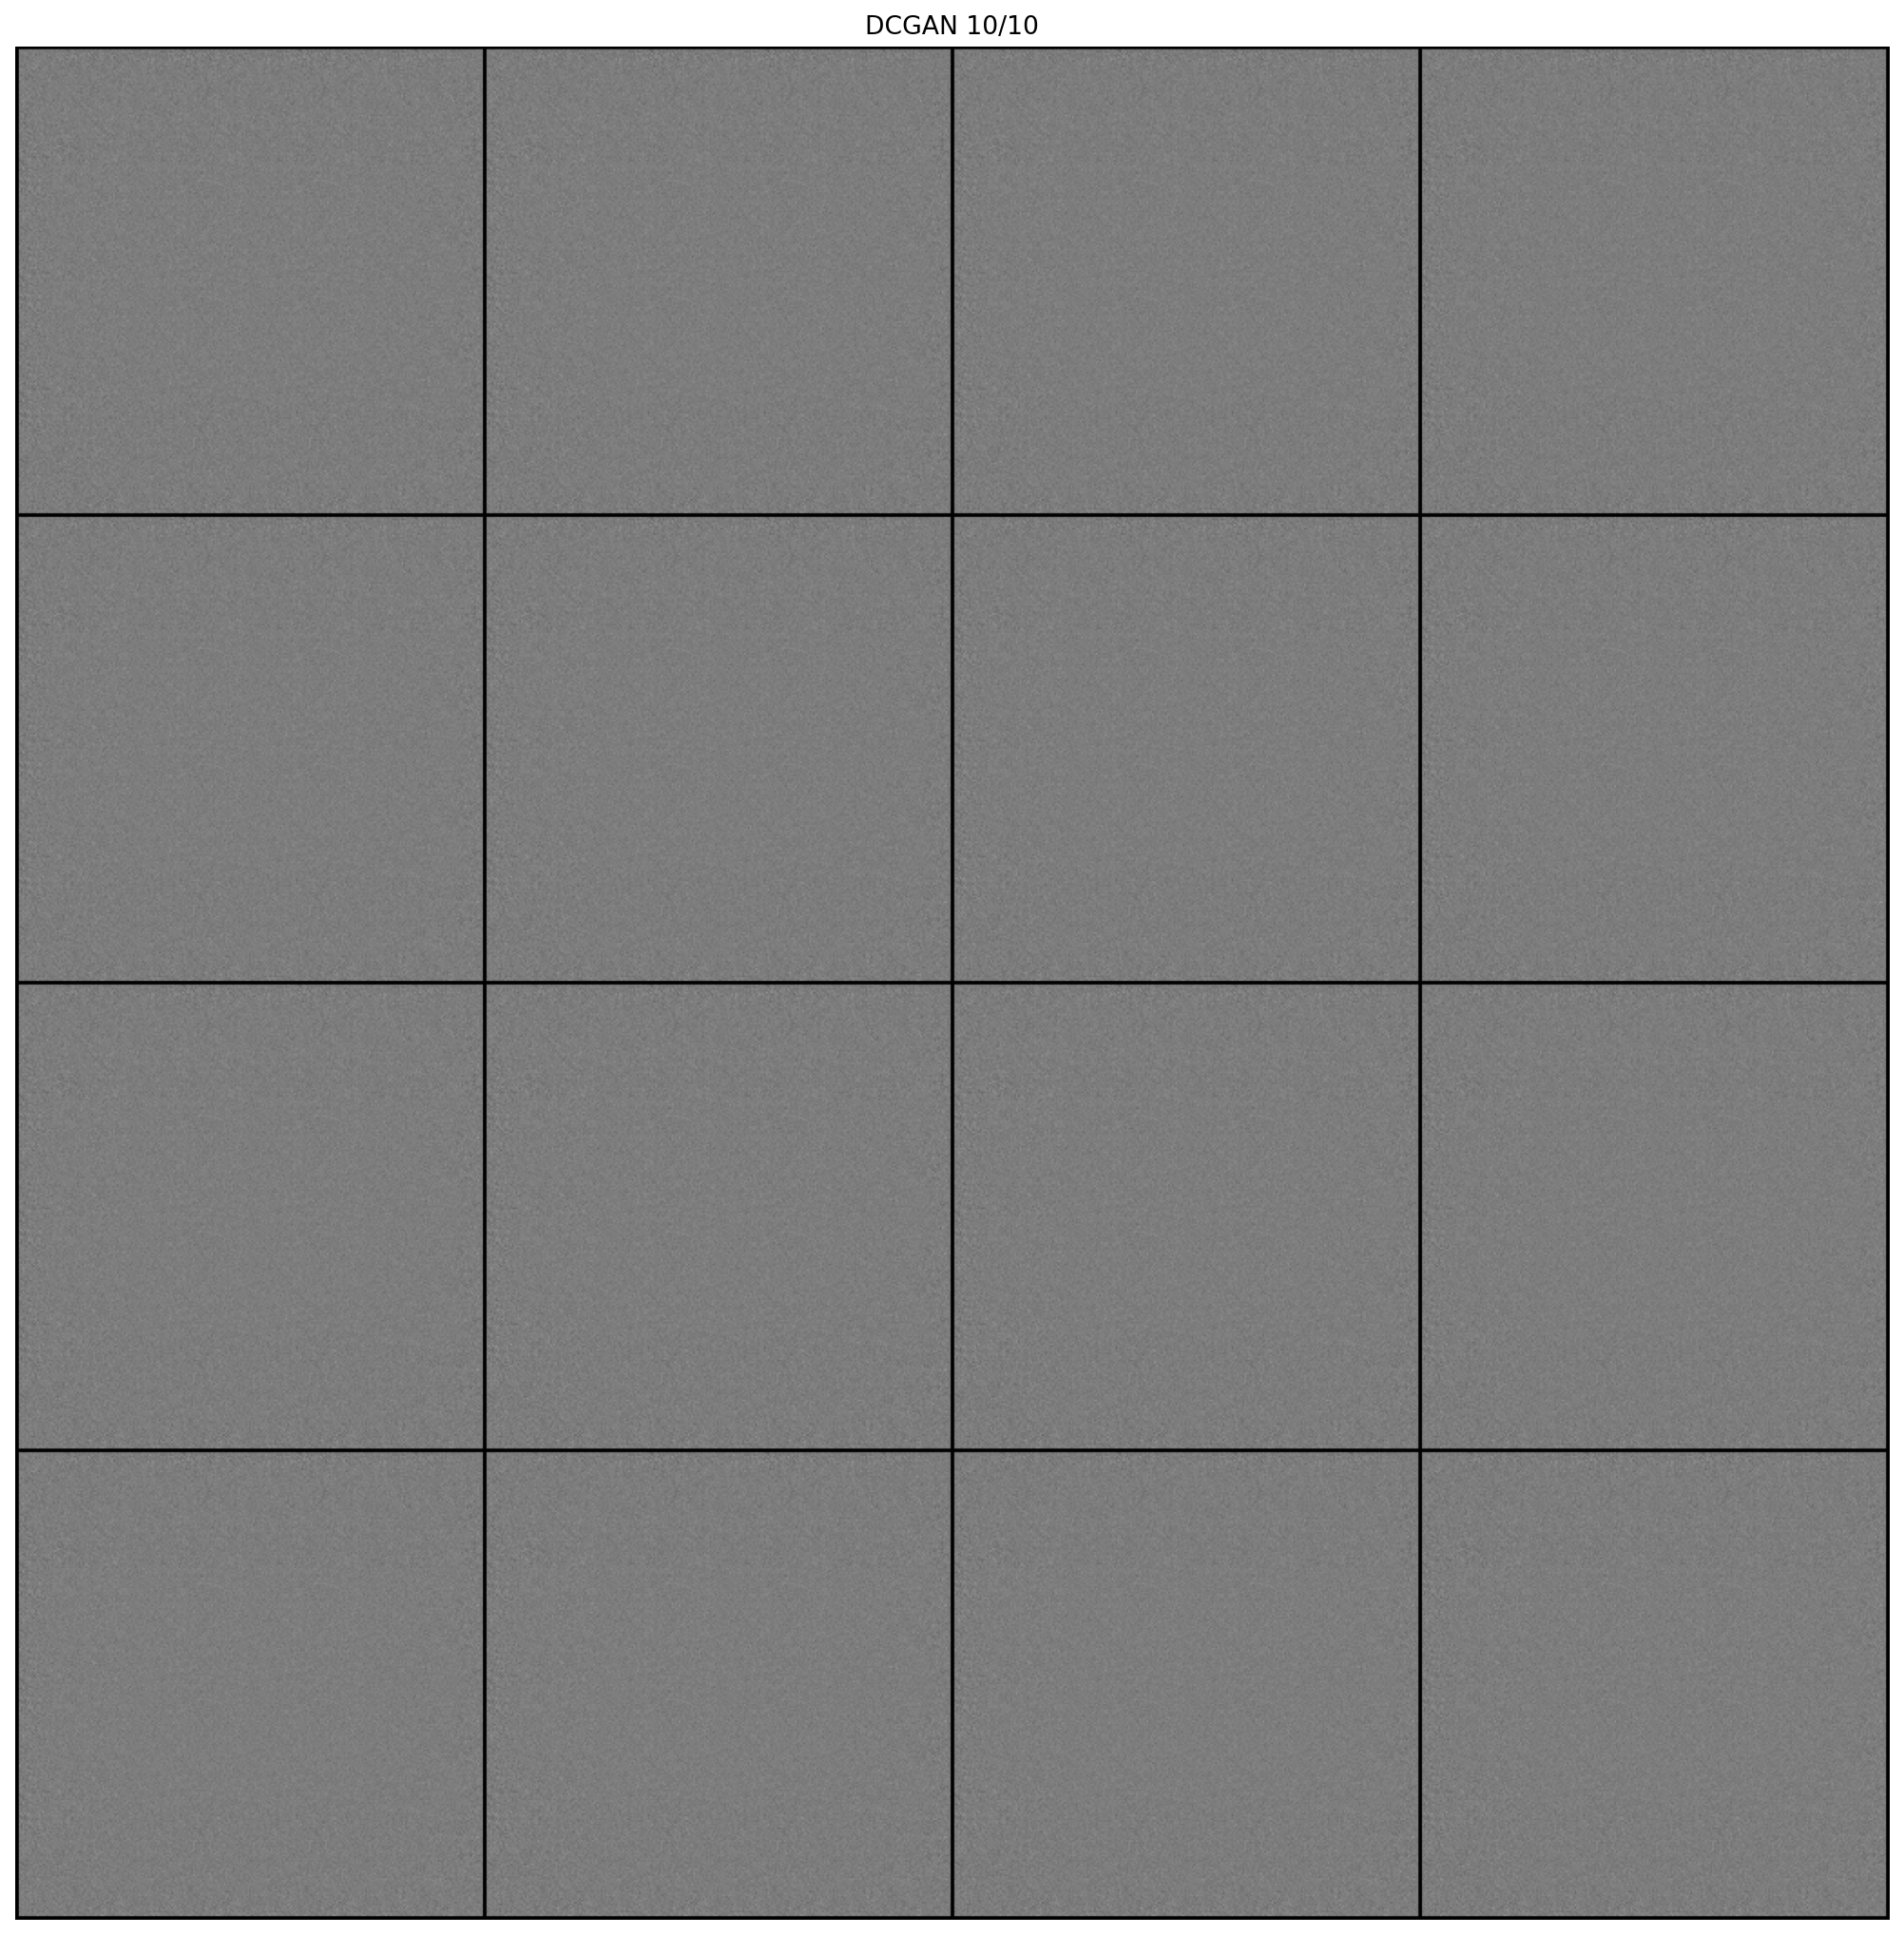

DCGAN 10 epochs.: 100%|██████████| 10/10 [01:57<00:00, 11.73s/it]


Gen Images Size: torch.Size([16, 1, 256, 256])


In [72]:
for epoch in tqdm(range(EPOCHS), desc=f"DCGAN {EPOCHS} epochs."):
    for i, batch in enumerate(loader):

        real_images = batch.to(DEVICE)

        valid = torch.ones(real_images.size(0), 1, device=DEVICE)
        fake = torch.zeros(real_images.size(0), 1, device=DEVICE)

        real_images = real_images.to(DEVICE)

        DC_optimizer_D.zero_grad()

        z = torch.randn(real_images.size(0), LATENT_DIM, device=DEVICE)

        fake_images = DC_generator(z)

        real_loss = DC_adversarial_loss(DC_discriminator(real_images), valid)
        fake_loss = DC_adversarial_loss(DC_discriminator(fake_images.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        DC_optimizer_D.step()

        DC_optimizer_G.zero_grad()

        gen_images = DC_generator(z)

        g_loss = DC_adversarial_loss(DC_discriminator(gen_images), valid)
        g_loss.backward()
        DC_optimizer_G.step()

        if (i + 1) % 100 == 0:
            print(
                f"Epoch [{epoch+1}/{EPOCHS}]\
                        Batch {i+1}/{len(loader)} "
                f"Discriminator Loss: {d_loss.item():.4f} "
                f"Generator Loss: {g_loss.item():.4f}"
            )
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            z = torch.randn(16, LATENT_DIM, device=DEVICE)
            generated = DC_generator(z).detach().cpu()
            # grid = make_grid(generated, nrow=4, normalize=True)
            # plt.imshow(np.transpose(grid, (1, 2, 0)))
            # plt.axis("off")
            # plt.show()
            show_grid(generated, nrow=4, title=f"DCGAN {epoch + 1}/{EPOCHS}")
            print(f"\nGen Images Size: {generated.size()}")

## Evaluation